# Algorithm comparison & Results
1. Load dataset 
2. Explore data
3. Prepare data
4. Build model
5. Parameter optimization - two highest accuracy algorithm 
6. T-test(paired sample) - compare highest two algorithm 


In [2]:
__all__ = ['load_data', 'clean_text', 'preprocess_corpus', 'encode_labels', 'compute_tfidf', 'train_test_model']

import os
import time
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

from sklearn import ensemble
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score

In [3]:
def load_data(file_path):
    """ Load the csv file and return a Dataframe. """
    df = pd.read_csv(file_path, delimiter=',')
    return df

def clean_text(text):
    """ clean the text by removing special characters, punctuations, etc. """
    text = text.lower()
    remove_xx_seq  = re.compile('xx+')
    replace_by_space = re.compile('[/(){}\[\]\|@,;]')
    remove_special_characters = re.compile('[^0-9a-z +]')
    remove_extra_space = re.compile('[^A-Za-z0-9]+')
    remove_numbers = re.compile('[0-9]+')
    text = re.sub(remove_xx_seq, ' ', text)
    text = re.sub(replace_by_space, ' ', text)
    text = re.sub(remove_special_characters, ' ', text)
    text = re.sub(remove_numbers, ' ', text)
    text = re.sub(remove_extra_space, ' ', text)
    return text.strip()


def preprocess_corpus(df, column='text'):
    """ Preprocess the entire corpus including cleaning the text documents and return the updated dataframe. """
    df[column] = df[column].apply(clean_text)
    return df

def encode_labels(labels):
    """ Encode the class labels into a numbers. """
    label_encoder = preprocessing.LabelEncoder()
    label_encoder.fit(labels)
    return label_encoder

def compute_tfidf(corpus, stop_words='english', ngram_range=(1, 1), max_features=None):
    """ Calculate the tfidf features for all the text documents and return a (documents, fatures) matrix. """
    vectorizer = TfidfVectorizer(input='content', stop_words=stop_words, ngram_range=ngram_range, min_df=3, max_df=0.9, max_features=max_features)
    print('Computing tfidf features...', end='')
    X = vectorizer.fit_transform(corpus)
    print('done!')
    return X, vectorizer


def train_test_model(model, X_train, X_test, y_train, y_test,labels):
    """ Train and test the model using the training and test data sets. Return the predictions, accuracy and metric reports. """
    print('Start training...', end='')
    model.fit(X_train, y_train)
    print('done!')
    print('Start testing...', end='')
    predictions = model.predict(X_test)
    accuracy = model.score(X_test, y_test)
    metrics_report = classification_report(y_test, predictions, target_names=labels)
    precision, recall, fscore, train_support = score(y_test, predictions, average='weighted')
    print('done!')
    return predictions, accuracy, metrics_report, (precision, recall, fscore)

In [4]:
file_path = os.path.join('text_alli.csv')
print('Load the data...', end='')
df = load_data(file_path)
print('done.')

Load the data...done.


In [5]:
df.head()

,UserName,Handle,Timestamp,text,Type
0,Media Selangor,@Media_Selangor,2021-01-01T12:45:02.000Z,Selangor Journal | Bangkok to close schools fo...,Global
1,ð“¢ð“¾ð“»ð“°ð“ªð“»ð“¸ð“¾ð“½ð“®,@SurgaRoute,2021-01-01T12:44:02.000Z,PKPP throughout the country continued until ma...,"News, Malaysia"
2,Air Times News Network,@TheAirTimes,2021-01-01T12:38:57.000Z,PKPP nationwide is extended due to significant...,"News, Malaysia"
3,BERNAMA,@bernamadotcom,2021-01-01T12:36:24.000Z,"#COVID-19 : Three new clusters detected today,...",Cluster
4,Noor Hisham Abdullah,@DGHisham,2021-01-01T12:32:20.000Z,Pillars of Islam have 5 things and paying zaka...,"News, Malaysia"


the data is being load to continue further examination 

Number of categories:  ['Global' 'News, Malaysia' 'Cluster' 'Vaccine' 'Deaths' 'Cases'
 'Entertainment' 'Politic']



<AxesSubplot:title={'center':'Categories vs Number of Documents'}>

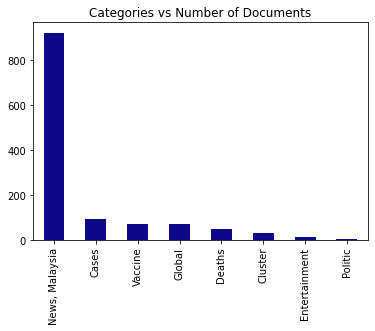

In [5]:
categories = df.Type.unique()
print('Number of categories: ', categories)
print()
df.Type.value_counts().plot(kind='bar', title='Categories vs Number of Documents', cmap='plasma')

the bar chart shows that the dataset is imbalanced, as the classes of each category is not equally divided. In the chart above shows that News, Malaysia have more number than other categories. 
To deal with imbalanced dataset, I use stratify method to complete the data training so that my data is more stable and can be used for other algorithm. I used stratified kfold cross validation and train-test split method to help handling in the imbalanced dataset. 


Text(0.5, 1.0, 'Word count vs Number of documents')

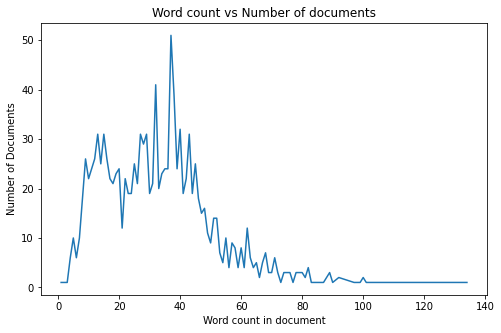

In [6]:
# Create a dataframe that contain number of words for each document 
dlength_df = pd.DataFrame({'doc_length': df.text.apply(lambda x: len(x.split()))})

# Group the documents based on their number of words 
grouped = dlength_df.groupby('doc_length')

indices = grouped.indices
word_count = []
doc_count = []
counter = 0
for w,d in indices.items():
    word_count.append(w)
    doc_count.append(len(d))

# Plot the distribution of words vs documents in the corpus
plt.figure(figsize=(8,5))
plt.plot(word_count, doc_count)
plt.xlabel('Word count in document')
plt.ylabel('Number of Documents')
plt.title('Word count vs Number of documents')

this chart to show that words count in document. the maximum words is not more than 100 words per tweet and the mostly the tweets are 40 word count in every tweets. 

In [7]:
# Randomly show 3 tweet 
samples = [np.random.randint(len(df)) for i in range(3)]
for index in samples:
    print(df['text'][index])
    print()

The MAEPS quarantine centre has increased bed capacity by over 3,000, to 6,132 beds. Deputy DG Dr Rohaizat Yon says this is to accommodate the increase in Covid-19 cases.

This follows reports that asymptomatic patients will have to self-isolate before being taken to hospital.Quote Tweet
BFM News
@NewsBFM
 Â· Dec 28, 2020
1. The Malay Mail reports that Health DG Dr Noor Hisham has advised those who have tested positive for Covid-19 but are asymptomatic, to isolate at home as they may not be taken to hospitals immediately, due to the number of cases and logistics issues in transporting patients.
Show this thread

#AGENSI Klang record highest #Covid19 two consecutive https://selangorkini.my/2020/12/klang-rekod-kes-covid-19-tertinggi-dua-hari-berturut/?utm_source=dlvr.it&utm_medium=twitterâ days in ¦

It is also expecting 1% of total annual out volume to be affected, citing mandatory self-isolation, which will in turn affect 25% of its capacity for the next two weeks.

https://bit.ly/37n3

In [8]:
# Preprocess the corpus - clean the dataset 
print('Cleaning the text...', end='')
df = preprocess_corpus(df, column='text')
print('done.')


Cleaning the text...done.


preprocess - to clean the data before use for develop a model. 
steps taken for preprocess
1. removing stop words
2. lowercase the text 
3. removing punctuations
4. a;phanumeric and special characters
5. remove extra space

In [9]:
# Create tfidf features from the text
stop_words    = 'english'
ngram_range   = (1, 1)
max_features  = None
X, vectorizer = compute_tfidf(df['text'], stop_words, ngram_range, max_features)

# Encode the labels
labels = df.Type.unique()
label_encoder = encode_labels(labels)
y = label_encoder.transform(df.Type)

Computing tfidf features...done!


prepare for data preparation - convert to tf-idf
bag-of-words is not being used as the tf-idf weighted more than the bag-of-words
1. remove stopwords
2. utilize unigram
3. use all features(text)
4. encode the class labels into numbers 

In [10]:
# Split the dataset to training and testing: used  8:2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
print('Training set Shape: {}  | Test set Shape: {}'.format(X_train.shape, X_test.shape))


Training set Shape: (1001, 1561)  | Test set Shape: (251, 1561)


to maintain the division of classes for training and testing set. 

Different model used to build the model and comparing the multiclass classification. the techniques use are: Naive Bayes, Logistic Regression, Random Forest, Support Vector Machine

Number of documents = 1001  |  Number of features = 1561
Start training...done!
Start testing...

c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

done!
Total time: 0.31s
accuracy: 0.749003984063745
                precision    recall  f1-score   support

        Global       1.00      0.06      0.11        18
News, Malaysia       0.00      0.00      0.00         6
       Cluster       0.00      0.00      0.00        10
       Vaccine       0.00      0.00      0.00         3
        Deaths       0.00      0.00      0.00        14
         Cases       0.75      1.00      0.86       185
 Entertainment       0.00      0.00      0.00         1
       Politic       0.67      0.14      0.24        14

      accuracy                           0.75       251
     macro avg       0.30      0.15      0.15       251
  weighted avg       0.66      0.75      0.65       251



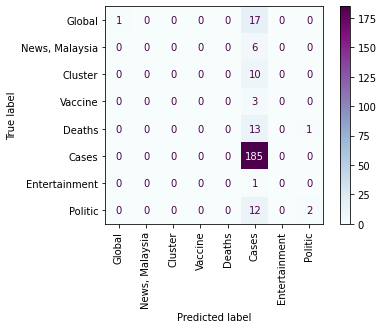

In [11]:
nb_model = MultinomialNB()
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, nb_prf = train_test_model(nb_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(nb_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")
plt.show()


Number of documents = 1001  |  Number of features = 1561
Start training...done!
Start testing...done!
Total time: 1.63s
accuracy: 0.7689243027888446
                precision    recall  f1-score   support

        Global       0.29      0.11      0.16        18
News, Malaysia       1.00      0.67      0.80         6
       Cluster       0.60      0.30      0.40        10
       Vaccine       0.00      0.00      0.00         3
        Deaths       0.00      0.00      0.00        14
         Cases       0.78      0.97      0.86       185
 Entertainment       0.00      0.00      0.00         1
       Politic       0.83      0.36      0.50        14

      accuracy                           0.77       251
     macro avg       0.44      0.30      0.34       251
  weighted avg       0.69      0.77      0.71       251



c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

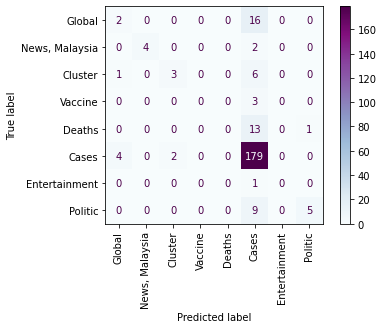

In [12]:
log_model = LogisticRegression(penalty='l2', max_iter=500)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, log_prf = train_test_model(log_model, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(log_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

Number of documents = 1001  |  Number of features = 1561
Start training...done!
Start testing...done!
Total time: 0.28s
accuracy: 0.796812749003984
                precision    recall  f1-score   support

        Global       0.38      0.17      0.23        18
News, Malaysia       0.86      1.00      0.92         6
       Cluster       0.50      0.80      0.62        10
       Vaccine       1.00      0.67      0.80         3
        Deaths       1.00      0.14      0.25        14
         Cases       0.86      0.93      0.89       185
 Entertainment       0.00      0.00      0.00         1
       Politic       0.44      0.50      0.47        14

      accuracy                           0.80       251
     macro avg       0.63      0.53      0.52       251
  weighted avg       0.79      0.80      0.77       251



c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

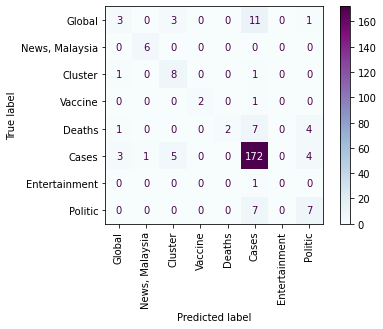

In [13]:
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
st_time = time.time()
predictions, accuracy, metrics_report, svm_prf = train_test_model(svm, X_train, X_test, y_train, y_test, labels)
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(svm, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

Number of documents = 1001  |  Number of features = 1561
Start training...done!
Start testing...

c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

done!
Total time: 3.68s
accuracy: 0.7808764940239044
                precision    recall  f1-score   support

        Global       0.30      0.17      0.21        18
News, Malaysia       1.00      0.83      0.91         6
       Cluster       0.67      0.60      0.63        10
       Vaccine       1.00      0.33      0.50         3
        Deaths       0.00      0.00      0.00        14
         Cases       0.82      0.95      0.88       185
 Entertainment       0.00      0.00      0.00         1
       Politic       0.50      0.43      0.46        14

      accuracy                           0.78       251
     macro avg       0.54      0.41      0.45       251
  weighted avg       0.71      0.78      0.74       251



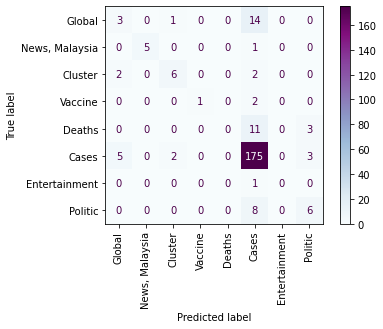

In [14]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)
print('Number of documents = {}  |  Number of features = {}'.format(X_train.shape[0], X_train.shape[1]))
 
print('accuracy: {}'.format(accuracy))
print('='*100)
print(metrics_report)
plot_confusion_matrix(rf_model, X_test, y_test, display_labels=labels, xticks_rotation='vertical', cmap="BuPu")

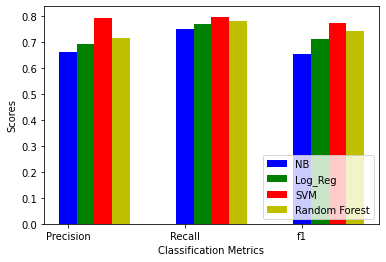

In [15]:
xx = np.array([1,2,3])
width = 0.15
ax = plt.subplot(111)
ax.bar( xx - width, height=np.array(nb_prf), width=width, color='b', align='center', label='NB', tick_label=['Precision', 'Recall', 'f1'])
ax.bar(xx ,height=np.array(log_prf), width=width, color='g', align='center', label='Log_Reg')
ax.bar(xx + width, height=np.array(svm_prf), width=width, color='r', align='center', label='SVM')
ax.bar(xx + 2*width, height=np.array(rf_prf), width=width, color='y', align='center', label='Random Forest')

plt.xlabel('Classification Metrics')
plt.ylabel('Scores')
plt.legend(loc='lower right')
plt.show()


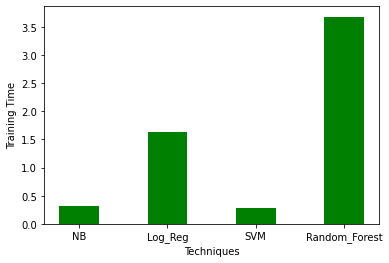

In [32]:
tr_times = [('NB', 0.31), ('Log_Reg', 1.63), ('SVM', 0.28), ('Random_Forest', 3.68)]
x_vals = []
h_vals = []
for t in tr_times:
    x_vals.append(t[0])
    h_vals.append(t[1])
    
ax = plt.subplot(111)
ax.bar(np.linspace(0,1,4) - width, height=np.array(h_vals), width=width, color='Green', tick_label=x_vals)
plt.xlabel('Techniques')
plt.ylabel('Training Time')
plt.show()

# Cross Validation
cross validation(stratifiedkfold) is the method to handle the imbalanced dataset 

In [17]:
skfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
nb_model = MultinomialNB()

accs = []
reports = []
f1_scores = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions, accuracy, metrics_report, nb_prf = train_test_model(nb_model, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    reports.append(metrics_report)
    
en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f}'.format(np.mean(accs)))


Start training...done!
Start testing...done!
Start training...done!

c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Start testing...done!
Total time: 0.32s
mean accuracy: 0.74


c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [18]:
log_model = LogisticRegression(penalty='l2', max_iter=100)
accs = []
reports = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions, accuracy, metrics_report, log_prf = train_test_model(log_model, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    reports.append(metrics_report)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time))   
print('mean accuracy: {:.2f}'.format(np.mean(accs)))

Start training...done!
Start testing...done!
Start training...

c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

done!
Start testing...done!
Total time: 2.29s
mean accuracy: 0.76


c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

In [19]:
#svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=10000, tol=1e-4, C=0.1)
svm = LinearSVC(class_weight='balanced', verbose=False, max_iter=100, tol=1e-4, C=0.1)
accs = []
reports = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions, accuracy, metrics_report, svm_prf = train_test_model(svm, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    reports.append(metrics_report)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time)) 
print('mean accuracy: {:.2f}'.format(np.mean(accs)))

Start training...done!
Start testing...done!
Start training...done!

c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Start testing...done!
Total time: 0.32s
mean accuracy: 0.81


In [20]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_split=10, n_jobs=-1, verbose=0)
accs = []
reports = []
st_time = time.time()
for train_index, test_index in skfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    predictions, accuracy, metrics_report, rf_prf = train_test_model(rf_model, X_train, X_test, y_train, y_test, labels)
    accs.append(accuracy)
    reports.append(metrics_report)

en_time = time.time()
print('Total time: {:.2f}s'.format(en_time-st_time)) 
print('mean accuracy: {:.2f}'.format(np.mean(accs)))


Start training...done!
Start testing...

c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

done!
Start training...done!
Start testing...done!
Total time: 7.32s
mean accuracy: 0.78


c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

# parameter optimization

Modeling algorithms based on the highest accuracy SVM - 80%, RF - 78%
1. SVM
2. Random forest


c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  %

c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  %

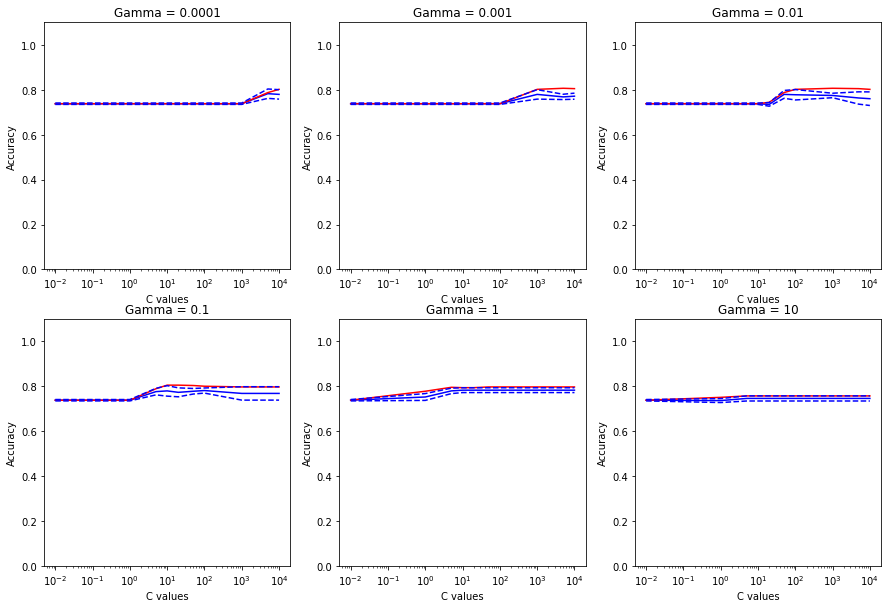

In [21]:
c_list = [0.01, 1, 5, 10, 20, 50, 100, 1000, 5000, 10000]
gamma_list = [0.0001, 0.001, 0.01, 0.1, 1, 10]

i = 0
plt.figure(figsize=(15,10))

for gamma_value in gamma_list:

  i = i + 1
  scores = list()
  score_stds = list()
  score_tests = list()

  for c_value in c_list:

    clf_cv = SVC(C=c_value, gamma=gamma_value)
    cv_score = cross_val_score(clf_cv, X_train, y_train)
    scores.append(np.mean(cv_score))
    score_stds.append(np.std(cv_score))
    clf_cv.fit(X_train, y_train)
    score_test = clf_cv.score(X_test, y_test)
    score_tests.append(score_test)

  plt.subplot(2,3,i)
  plt.semilogx(c_list, scores, 'b')
  plt.semilogx(c_list, score_tests, 'r')
  plt.semilogx(c_list, np.array(scores)+np.array(score_stds), 'b--')
  plt.semilogx(c_list, np.array(scores)+-np.array(score_stds), 'b--')
  plt.title('Gamma = {}'.format(gamma_value))
  plt.xlabel('C values')
  plt.ylabel('Accuracy')
  plt.ylim(0,1.1)

plt.show()


Gamma = 1 and C = 10 give the best accuracy.

SVM classifier training

In [22]:
clf = SVC(C=10, gamma=1)
clf.fit(X_train, y_train)

SVC(C=10, gamma=1)

In [33]:
def plot_confusion_matrix(cm, classes,normalize,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

                precision    recall  f1-score   support

        Global       0.48      0.30      0.37        46
News, Malaysia       1.00      0.47      0.64        15
       Cluster       0.56      0.40      0.47        25
       Vaccine       1.00      0.50      0.67         6
        Deaths       0.88      0.20      0.33        35
         Cases       0.82      0.97      0.89       462
 Entertainment       0.00      0.00      0.00         2
       Politic       0.67      0.17      0.27        35

      accuracy                           0.79       626
     macro avg       0.67      0.38      0.45       626
  weighted avg       0.78      0.79      0.76       626

Normalized confusion matrix


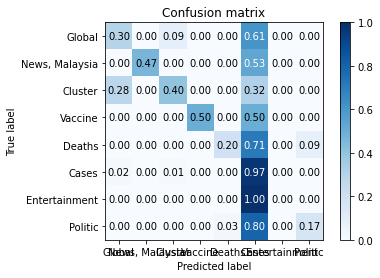

In [24]:
pred_test = clf.predict(X_test)
target_list = ['Global',
 'News, Malaysia',
 'Cluster',
 'Vaccine',
 'Deaths',
 'Cases',
 'Entertainment',
 'Politic']
print(classification_report(y_test, pred_test, target_names=target_list))
cm_test_SVM = confusion_matrix(y_test, pred_test)
plot_confusion_matrix(cm_test_SVM, target_list, normalize=True)

Random forest (RF) parameter optimization

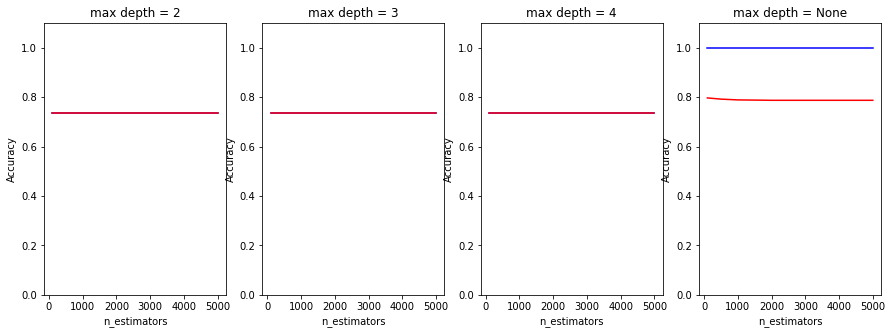

In [25]:
max_depths = [2, 3, 4]
n_estimators_list = [100, 500, 1000, 2000, 5000]

i = 0
plt.figure(figsize=(15,5))

for depth in max_depths:

  i = i + 1
  scores = list()
  score_tests = list()

  for est in n_estimators_list:

    params = {'n_estimators': est, ##  number of iterations, int, default=100
          'max_depth': depth, ##  int, default=3
          }
    clf_cv = ensemble.RandomForestClassifier(**params)
    clf_cv.fit(X_train, y_train)
    cv_score = clf_cv.score(X_train, y_train)
    scores.append(np.mean(cv_score))
    score_test = clf_cv.score(X_test, y_test)
    score_tests.append(score_test)

  plt.subplot(1,4,i)
  plt.plot(n_estimators_list, scores, 'b')
  plt.plot(n_estimators_list, score_tests, 'r')
  plt.title('max depth = {}'.format(depth))
  plt.xlabel('n_estimators')
  plt.ylabel('Accuracy')
  plt.ylim(0,1.1)

scores = list()
score_tests = list()
for est in n_estimators_list:
  clf_cv = ensemble.RandomForestClassifier(n_estimators=est)
  clf_cv.fit(X_train, y_train)
  cv_score = clf_cv.score(X_train, y_train)
  scores.append(np.mean(cv_score))
  score_test = clf_cv.score(X_test, y_test)
  score_tests.append(score_test)
plt.subplot(1,4,4)
plt.plot(n_estimators_list, scores, 'b')
plt.plot(n_estimators_list, score_tests, 'r')
plt.title('max depth = {}'.format('None'))
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.show()

RF classifier training

c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


[0.75396825 0.816      0.752      0.776      0.768     ]


c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\sadiqah amira\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

              precision    recall  f1-score   support

           0       0.47      0.20      0.28        46
           1       1.00      0.40      0.57        15
           2       0.61      0.44      0.51        25
           3       1.00      0.33      0.50         6
           4       1.00      0.11      0.21        35
           5       0.81      0.97      0.88       462
           6       0.00      0.00      0.00         2
           7       0.50      0.31      0.39        35

    accuracy                           0.78       626
   macro avg       0.67      0.35      0.42       626
weighted avg       0.77      0.78      0.74       626

Normalized confusion matrix


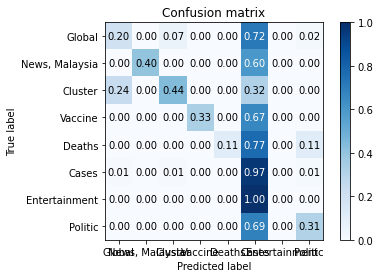

In [26]:
clf_RF = ensemble.RandomForestClassifier(n_estimators=2000)
print(cross_val_score(clf_RF, X_train, y_train, cv=5))
clf_RF.fit(X_train, y_train)
preds_RF = clf_RF.predict(X_test)
print(classification_report(y_test, preds_RF))
cm_test_RF = confusion_matrix(y_test, preds_RF)
plot_confusion_matrix(cm_test_RF, target_list, normalize=True)

In [27]:
### To create a data frame recording the correct prediction (normalized) of facies for each machine learning algorithm

mod_test_list = ['SVM','RF',]
cm_test_list = [cm_test_SVM, cm_test_RF]
face_test_list = ['Global',
 'News, Malaysia',
 'Cluster',
 'Vaccine',
 'Deaths',
 'Cases',
 'Entertainment',
 'Politic']
pred_test_df = pd.DataFrame(index=target_list, columns=mod_test_list)

for mod in mod_test_list:
  col_index = int(mod_test_list.index(mod))
  cm = cm_test_list[col_index]

  for face in face_test_list:
    row_index = target_list.index(face)
    #print(face, row_index, col_index)
    pred_test_df.iloc[row_index, col_index] = cm[row_index][row_index]/sum(cm[row_index])

### add the accuracy factor
df_1 = pd.DataFrame([[0.79, 0.79]], index=['Accuracy'], columns=mod_test_list)    
pred_test_df = pred_test_df.append(df_1)

print(pred_test_df.head(10))

                     SVM        RF
Global          0.304348  0.195652
News, Malaysia  0.466667       0.4
Cluster              0.4      0.44
Vaccine              0.5  0.333333
Deaths               0.2  0.114286
Cases           0.974026  0.969697
Entertainment          0         0
Politic         0.171429  0.314286
Accuracy            0.79      0.79


model performance evaluation

I will use the diagnosis of confusion matrix from train data set to evaluate the model performance. 
The diagnosis of confusion matrix points how much percentage of the categories of classes is correctly predicted

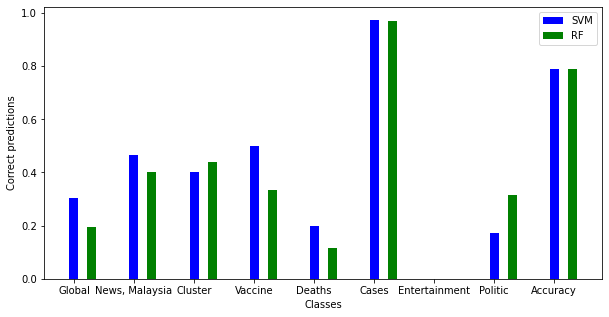

In [28]:
X_ind = np.arange(pred_test_df.shape[0])
(pred_df_index_list) = ['Global',
 'News, Malaysia',
 'Cluster',
 'Vaccine',
 'Deaths',
 'Cases',
 'Entertainment',
 'Politic','Accuracy']
plt.figure(figsize=(10,5))
plt.bar(X_ind, pred_test_df['SVM'], color='b', width=0.15)
#plt.bar(X_ind+0.15, pred_test_df['GB'], color='r', width=0.15)
plt.bar(X_ind+0.3, pred_test_df['RF'], color='g', width=0.15)
#plt.bar(X_ind+0.45, pred_test_df['KNN'], color='y', width=0.15)
plt.xticks(X_ind, pred_df_index_list)
plt.xlabel('Classes')
plt.ylabel('Correct predictions')
plt.legend(labels=mod_test_list)
plt.show()

SVM and RF both predict 0 Entertainment, which is consistent for both algorithm
SVM, RF present a same accuracy score. 

SVM could correctly predict much more for (Global), (News, Malaysia), (Vaccine), (Death Cases) than the RF, while RF have the same correct prediction for other classes categories that is Cases.


# A-B test to evaluate the difference in F1 score:

Get the F1 score 100 times for each algorithms
A-B test on the average F1 between RF and SVM

RANDOM FOREST 

In [30]:
list0 = []
for i in range(0,100,1):
  X_train0, X_test0, y_train0, y_test0 = train_test_split(X, y, test_size=0.05)
  clf0 = ensemble.RandomForestClassifier(n_estimators=2000)
  clf0.fit(X_train0, y_train0)
  list0.append(clf0.score(X_test0, y_test0))
  print(i, clf0.score(X_test0, y_test0))

0 0.7936507936507936
1 0.7777777777777778
2 0.9047619047619048
3 0.8095238095238095
4 0.8253968253968254
5 0.7936507936507936
6 0.8095238095238095
7 0.8253968253968254
8 0.7936507936507936
9 0.8095238095238095
10 0.746031746031746
11 0.7936507936507936
12 0.8412698412698413
13 0.746031746031746
14 0.8095238095238095
15 0.8571428571428571
16 0.7777777777777778
17 0.6984126984126984
18 0.8095238095238095
19 0.8888888888888888
20 0.7936507936507936
21 0.7936507936507936
22 0.8412698412698413
23 0.8412698412698413
24 0.8253968253968254
25 0.8095238095238095
26 0.8253968253968254
27 0.7777777777777778
28 0.873015873015873
29 0.7777777777777778
30 0.8253968253968254
31 0.873015873015873
32 0.7777777777777778
33 0.7777777777777778
34 0.8412698412698413
35 0.6984126984126984
36 0.7777777777777778
37 0.8412698412698413
38 0.8253968253968254
39 0.8412698412698413
40 0.7936507936507936
41 0.9206349206349206
42 0.7777777777777778
43 0.6984126984126984
44 0.7301587301587301
45 0.8095238095238095
46

array([[<AxesSubplot:title={'center':'RF'}>]], dtype=object)

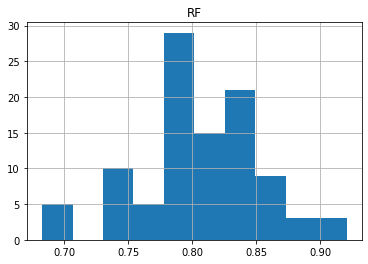

In [31]:
df0 = pd.DataFrame(list0, columns=['RF'])
df0.hist()

In [37]:
from sklearn.preprocessing import StandardScaler

In [39]:
#Data for modelling

scaler = StandardScaler(with_mean=False).fit(X)
X_stnd = scaler.transform(X)

#standarization of data for SVM
X_train, X_test, y_train, y_test = train_test_split(X_stnd, y, test_size=0.05, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.05, random_state=42)

SVM

In [40]:
list0 = []
for i in range(0,100,1):
  X_train0, X_test0, y_train0, y_test0 = train_test_split(X_stnd, y, test_size=0.05)
  clf0 = SVC(C=10, gamma=1)
  clf0.fit(X_train0, y_train0)
  list0.append(clf0.score(X_test0, y_test0))
  print(i, clf0.score(X_test0, y_test0))

0 0.7936507936507936
1 0.7301587301587301
2 0.8095238095238095
3 0.6825396825396826
4 0.7936507936507936
5 0.6984126984126984
6 0.7936507936507936
7 0.7301587301587301
8 0.6349206349206349
9 0.7142857142857143
10 0.7142857142857143
11 0.7777777777777778
12 0.6984126984126984
13 0.7301587301587301
14 0.7142857142857143
15 0.6984126984126984
16 0.6984126984126984
17 0.7619047619047619
18 0.7936507936507936
19 0.7301587301587301
20 0.8253968253968254
21 0.7777777777777778
22 0.7936507936507936
23 0.7619047619047619
24 0.8095238095238095
25 0.7142857142857143
26 0.7936507936507936
27 0.8095238095238095
28 0.7142857142857143
29 0.6984126984126984
30 0.6507936507936508
31 0.746031746031746
32 0.7142857142857143
33 0.746031746031746
34 0.7142857142857143
35 0.7936507936507936
36 0.7301587301587301
37 0.7936507936507936
38 0.746031746031746
39 0.7142857142857143
40 0.7777777777777778
41 0.6825396825396826
42 0.8095238095238095
43 0.6984126984126984
44 0.746031746031746
45 0.7301587301587301
46

array([[<AxesSubplot:title={'center':'SVM'}>]], dtype=object)

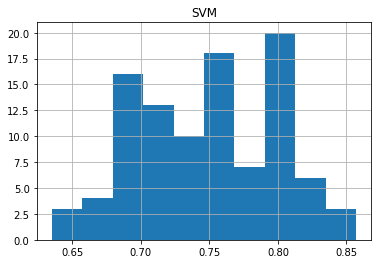

In [41]:
df1 = pd.DataFrame(list0, columns=['SVM'])
df1.hist()

In [43]:
from scipy import stats

In [46]:
stats.ttest_ind(df0['RF'],df1['SVM'])

Ttest_indResult(statistic=7.930732851586143, pvalue=1.566334598297805e-13)

In [47]:
list_RF =[0.7936507936507936
,0.7777777777777778
,0.9047619047619048
,0.8095238095238095
,0.8253968253968254
,0.7936507936507936
,0.8095238095238095
,0.8253968253968254
,0.7936507936507936
,0.8095238095238095
,0.746031746031746
,0.7936507936507936
,0.8412698412698413
,0.746031746031746
,0.8095238095238095
,0.8571428571428571
,0.7777777777777778
,0.6984126984126984
,0.8095238095238095
,0.8888888888888888
,0.7936507936507936
,0.7936507936507936
, 0.8412698412698413
,0.8412698412698413
,0.8253968253968254
,0.8095238095238095
,0.8253968253968254
,0.7777777777777778
,0.873015873015873
, 0.7777777777777778
,0.8253968253968254
, 0.873015873015873
,0.7777777777777778
,0.7777777777777778
,0.8412698412698413
,0.6984126984126984
,0.7777777777777778
,0.8412698412698413
,0.8253968253968254
,0.8412698412698413
,0.7936507936507936
,0.9206349206349206
,0.7777777777777778
,0.6984126984126984
,0.7301587301587301
,0.8095238095238095
,0.8253968253968254
,0.7777777777777778
,0.8571428571428571
,0.7777777777777778
,0.7936507936507936
,0.7936507936507936
,0.746031746031746
, 0.8095238095238095
,0.7936507936507936
,0.746031746031746
,0.746031746031746
,0.9047619047619048
,0.7777777777777778
,0.746031746031746
,0.7619047619047619
,0.8095238095238095
,0.8095238095238095
,0.7777777777777778
,0.7777777777777778
,0.8095238095238095
,0.8253968253968254
,0.8571428571428571
,0.8412698412698413
,0.7777777777777778
,0.8253968253968254
,0.746031746031746
,0.8571428571428571
,0.7619047619047619
,0.7619047619047619
,0.746031746031746
,0.8095238095238095
, 0.7936507936507936
,0.7619047619047619
,0.8095238095238095
,0.8253968253968254
,0.8253968253968254
,0.8571428571428571
, 0.8095238095238095
,0.7619047619047619
,0.6984126984126984
,0.746031746031746
,0.8253968253968254
,0.8412698412698413
, 0.8571428571428571
,0.8571428571428571
,0.8253968253968254
,0.8571428571428571
,0.7777777777777778
,0.7936507936507936
,0.7936507936507936
,0.7936507936507936
,0.8095238095238095
,0.6825396825396826
,0.8571428571428571]

In [48]:
list_SVM =[0.7936507936507936
,0.7301587301587301
,0.8095238095238095
,0.6825396825396826
,0.7936507936507936
,0.6984126984126984
,0.7936507936507936
,0.7301587301587301
,0.6349206349206349
,0.7142857142857143
,0.7142857142857143
,0.7777777777777778
,0.6984126984126984
,0.7301587301587301
,0.7142857142857143
,0.6984126984126984
,0.6984126984126984
,0.7619047619047619
,0.7936507936507936
,0.7301587301587301
,0.8253968253968254
,0.7777777777777778
,0.7936507936507936
, 0.7619047619047619
,0.8095238095238095
,0.7142857142857143
,0.7936507936507936
,0.8095238095238095
,0.7142857142857143
,0.6984126984126984
, 0.6507936507936508
,0.746031746031746
,0.7142857142857143
,0.746031746031746
,0.7142857142857143
, 0.7936507936507936
,0.7301587301587301
,0.7936507936507936
,0.746031746031746
,0.7142857142857143
,0.7777777777777778
,0.6825396825396826
,0.8095238095238095
,0.6984126984126984
,0.746031746031746
,0.7301587301587301
,0.7142857142857143
,0.7777777777777778
,0.7142857142857143
,0.6349206349206349
,0.8095238095238095
,0.746031746031746
,0.746031746031746
,0.7936507936507936
,0.746031746031746
,0.7936507936507936
,0.6666666666666666
,0.7301587301587301
,0.7142857142857143
,0.6825396825396826
,0.8253968253968254
,0.6666666666666666
,0.6984126984126984
,0.6825396825396826
,0.8253968253968254
,0.8253968253968254
,0.746031746031746
,0.7619047619047619
,0.7936507936507936
,0.7301587301587301
,0.7936507936507936
,0.7619047619047619
,0.7777777777777778
,0.8253968253968254
,0.6666666666666666
,0.6825396825396826
,0.6984126984126984
,0.8095238095238095
,0.746031746031746
,0.8253968253968254
,0.7619047619047619
,0.7301587301587301
, 0.7619047619047619
,0.6825396825396826
,0.8571428571428571
,0.7777777777777778
,0.8095238095238095
,0.6825396825396826
,0.7301587301587301
,0.8412698412698413
,0.7142857142857143
,0.7777777777777778
,0.6666666666666666
,0.7619047619047619
,0.6825396825396826
,0.746031746031746
,0.8571428571428571
,0.7936507936507936
,0.7619047619047619
,0.7142857142857143]

In [50]:
df_RF = pd.DataFrame(list_RF, columns=['RF'])
df_GB = pd.DataFrame(list_SVM, columns=['SVM'])

In [51]:
from scipy import stats
stats.ttest_ind(df_RF['RF'],df_GB['SVM'])

Ttest_indResult(statistic=7.930732851586143, pvalue=1.566334598297805e-13)

 Ttest shows difference between between RF and SVM is significant pvalue=pvalue=1.566334598297805e-13